# Homework 3. Dense Prediction (50 points)
---
In this part, you will study a problem of segmentation. The goal of this assignment is to study, implement, and compare different components of dense prediction models, including **data augmentation**, **backbones**, **classifiers** and **losses**.

This assignment will require training multiple neural networks, therefore it is advised to use a **GPU** accelerator.

<font color='red'>**In this task, it is obligatory to provide accuracy plots on the training and validation datasets obtained during training, as well as examples of the work of each of the models on the images. Without plots, your work will get 0 points. Writing a report is just as important as writing code.**</font>

**<font color='red'>Before the submission please convert your notebook to .py file and check that it runs correctly. How to get .py file in Colab: File -> Download -> Download .py**

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# !pip install -U gdown
# !pip install pytorch_lightning

In [3]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'tiny-imagenet-2022.zip' is.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Colab Notebooks/SK DL 2022/HW2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

In [4]:
AUX_DATA_ROOT

WindowsPath('.')

In [5]:
# pass a python variable to console in brckets {}
!ls {'"%s"' % AUX_DATA_ROOT}

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [6]:
# Uncomment and run if in Colab
# !mkdir datasets
# !cp '{AUX_DATA_ROOT}/tiny-floodnet-challenge.tar.gz' datasets/tiny-floodnet-challenge.tar.gz
# !tar -xzf datasets/tiny-floodnet-challenge.tar.gz -C datasets
# !rm datasets/tiny-floodnet-challenge.tar.gz



In [7]:
!ls datasets/tiny-floodnet-challenge

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## Dataset

We will use a simplified version of a [FloodNet Challenge](http://www.classic.grss-ieee.org/earthvision2021/challenge.html).

Compared to the original challenge, our version doesn't have difficult (and rare) "flooded" labels, and the images are downsampled

<img src="https://i.imgur.com/RZuVuVp.png" />

## Assignments and grading


- **Part 1. Code**: fill in the empty gaps (marked with `#TODO`) in the code of the assignment (34 points):
    - `dataset` -- 4 points
    - `model` -- 20 points
    - `loss` -- 8 points
    - `train` -- 2 points
- **Part 2. Train and benchmark** the performance of the required models (6 points):
    - All 6 checkpoints are provided -- 3 points
    - Checkpoints have > 0.5 accuracy -- 3 points
- **Part 3. Report** your findings (10 points)
    - Each task -- 2.5 points

- **Total score**: 50 points.

For detailed grading of each coding assignment, please refer to the comments inside the files. Please use the materials provided during a seminar and during a lecture to do a coding part, as this will help you to further familiarize yourself with PyTorch. Copy-pasting the code from Google Search will get penalized.

In part 2, you should upload all your pre-trained checkpoints to your personal Google Drive, grant public access and provide a file ID, following the intructions in the notebook.

Note that for each task in part 3 to count towards your final grade, you should complete the corresponding tasks in part 2.

For example, if you are asked to compare Model X and Model Y, you should provide the checkpoints for these models in your submission, and their accuracies should be above minimal threshold.

## Part 1. Code


### `dataset`
**TODO: implement and apply data augmentations**

You'll need to study a popular augmentations library: [Albumentations](https://albumentations.ai/), and implement the requested augs. Remember that geometric augmentations need to be applied to both images and masks at the same time, and Albumentations has [native support](https://albumentations.ai/docs/getting_started/mask_augmentation/) for that.

In [8]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
import os
from PIL import Image
import numpy as np
import torch



class FloodNet(Dataset):
    """
    Labels semantic:
    0: Background, 1: Building, 2: Road, 3: Water, 4: Tree, 5: Vehicle, 6: Pool, 7: Grass
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,
    ):
        self.num_classes = 8
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size

        self.items = [filename.split('.')[0] for filename in os.listdir(f'{data_path}/{phase}/image')]
        
        # TODO: implement augmentations (3.5 points)
        if augment:
            # TODO:
            # Random resize
            # Random crop (within image borders, output size = img_size)
            # Random rotation
            # Random horizontal and vertical Flip
            # Random color augmentation
            
            self.transform = A.Compose([
                A.RandomResizedCrop(img_size, img_size),  # random resize + crop
                A.Rotate(),  # random rotate
                A.Flip(),  # random horizontal + vertical flip
                A.RGBShift(),  # random color augmentation
            ])

        else:
        	# TODO: random crop to img_size
            self.transform = A.RandomCrop(self.img_size, self.img_size)
        
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.jpg'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.png'))
        
        if self.phase == 'train':
        	# TODO: apply transform to both image and mask (0.5 points)
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()
        
        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor)
            assert image.shape == (3, self.img_size, self.img_size), img.shape
            assert isinstance(mask, torch.LongTensor)
            assert mask.shape == (self.img_size, self.img_size), mask.shape

        return image, mask

In [9]:
# fn = FloodNet('datasets/tiny-floodnet-challenge', 'train', False, 256)

In [10]:
# for img, msk in fn:
#     break

In [11]:
# img.shape

In [12]:
# data_path = 'datasets/tiny-floodnet-challenge'
# # phase = 'train'
# index = '10175'

In [13]:
# image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))

In [14]:
# image.shape

In [15]:
# img_size = 256

In [16]:
# transform = A.RandomCrop(img_size, img_size, p=.5)

In [17]:
# transformed = self.transform(image=image, mask=mask)
# image = transformed['image']
# mask = transformed['mask']

### `model`
**TODO: Implement the required models.**

Typically, all segmentation networks consist of an encoder and decoder. Below is a scheme for a popular DeepLab v3 architecture:

<img src="https://i.imgur.com/cdlkxvp.png" />

The encoder consists of a convolutional backbone, typically with extensive use of convs with dilations (atrous convs) and a head, which helps to further boost the receptive field. As you can see, the general idea for the encoders is to have as big of a receptive field, as possible.

The decoder either does upsampling with convolutions (similarly to the scheme above, or to UNets), or even by simply interpolating the outputs of the encoder.

In this assignment, you will need to implement **UNet** and **DeepLab** models. Example UNet looks like this:

<img src="https://i.imgur.com/uVdcE4e.png" />

For **DeepLab** model we will have three variants for backbones: **ResNet18**, **VGG11 (with BatchNorm)**, and **MobileNet v3 (small).** Use `torchvision.models` to obtain pre-trained versions of these backbones and simply extract their convolutional parts. To familiarize yourself with **MobileNet v3** model, follow this [link](https://paperswithcode.com/paper/searching-for-mobilenetv3).

We will also use **Atrous Spatial Pyramid Pooling (ASPP)** head. Its scheme can be seen in the DeepLab v3 architecture above. ASPP is one of the blocks which greatly increases the spatial size of the model, and hence boosts the model's performance. For more details, you can refer to this [link](https://paperswithcode.com/method/aspp).

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models


class ConvBnRelu(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_bn_relu = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
        )
        
    def forward(self, x):
        return self.conv_bn_relu(x)
    
    
class Down(nn.Module):
    
    def __init__(self, in_cannels, out_channels):
        super().__init__()
        
        self.conv_bn_relu = ConvBnRelu(in_cannels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))
    
    # Returns pooled image + skipped image for skip connection.
    def forward(self, x):
        
        x = self.conv_bn_relu(x)
        return self.pool(x), x
    
    
class Up(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        
        self.dropout = nn.Dropout()
        self.conv_bn_relu = ConvBnRelu(2 * out_channels, out_channels)
        
    def forward(self, x, skip):
        
        x = self.deconv(x)
        x = torch.cat([skip, x], dim=1)
        x = self.dropout(x)
        x = self.conv_bn_relu(x)
        
        return x


class UNet(nn.Module):
    """
    TODO: 8 points

    A standard UNet network (with padding in covs).

    For reference, see the scheme in materials/unet.png
    - Use batch norm between conv and relu
    - Use max pooling for downsampling
    - Use conv transpose with kernel size = 3, stride = 2, padding = 1, and output padding = 1 for upsampling
    - Use 0.5 dropout after concat

    Args:
      - num_classes: number of output classes
      - min_channels: minimum number of channels in conv layers
      - max_channels: number of channels in the bottleneck block
      - num_down_blocks: number of blocks which end with downsampling

    The full architecture includes downsampling blocks, a bottleneck block and upsampling blocks

    You also need to account for inputs which size does not divide 2**num_down_blocks:
    interpolate them before feeding into the blocks to the nearest size which divides 2**num_down_blocks,
    and interpolate output logits back to the original shape
    """
    def __init__(self, 
                 num_classes,
                 min_channels=32,
                 max_channels=512, 
                 num_down_blocks=4):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # TODO
        
        self.min_channels = min_channels
        self.max_channels = max_channels
        self.num_down_blocks = num_down_blocks
        
        self.in_channels = 3
        
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout()
        
        num_channels = [
            min(self.min_channels * 2**num_block, max_channels // 2) for num_block in range(self.num_down_blocks)
        ]
        
        in_channels_current = self.in_channels
        for n in num_channels:
            self.down_blocks.append(Down(in_channels_current, n))
            in_channels_current = n
            
        self.bottleneck = ConvBnRelu(num_channels[-1], 2 * num_channels[-1])
        
        for n in reversed(num_channels):
            self.up_blocks.append(Up(2 * n, n))
              
        self.out_conv = nn.Conv2d(min_channels, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # TODO
        
        x, new_shape = self.interp(inputs)
      
        skip_connections = []

        for down in self.down_blocks:
            x, skip = down(x)
            skip_connections.append(skip)
      
        x = self.bottleneck(x)
      
        for up, skip in zip(self.up_blocks, reversed(skip_connections)):
            x = up(x, skip)
      
        x = self.out_conv(x)
        x = self.sigmoid(x)

        if new_shape != inputs.shape:
            logits = F.interpolate(x, size=inputs.shape[-2:], mode='bilinear')
            
        else:
            logits = x
        

        assert logits.shape == (inputs.shape[0], self.num_classes, inputs.shape[2], inputs.shape[3]), 'Wrong shape of the logits'
        return logits
    
    def interp(self, x):
        
        divisor = 2**self.num_down_blocks
        
        if x.shape[2] % divisor != 0 or x.shape[3] % divisor != 0:
            new_shape = [divisor * round(x.shape[2] / divisor), divisor * round(x.shape[3] / divisor)]
            x = F.interpolate(x, size=new_shape, mode='bilinear')
            
        else:
            new_shape = x.shape[-2:]
            
        return x, new_shape


class DeepLab(nn.Module):
    """
    TODO: 6 points

    (simplified) DeepLab segmentation network.
    
    Args:
      - backbone: ['resnet18', 'vgg11_bn', 'mobilenet_v3_small'],
      - aspp: use aspp module
      - num classes: num output classes

    During forward pass:
      - Pass inputs through the backbone to obtain features
      - Apply ASPP (if needed)
      - Apply head
      - Upsample logits back to the shape of the inputs
    """
    def __init__(self, backbone, aspp, num_classes):
        super(DeepLab, self).__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.init_backbone()

        if aspp:
            self.aspp = ASPP(self.out_features, 256, [12, 24, 36])
        else:
            self.aspp = None

        self.head = DeepLabHead(self.out_features, num_classes)

    def init_backbone(self):
        # TODO: initialize an ImageNet-pretrained backbone
        
        assert self.backbone in {'resnet18', 'vgg11_bn', 'mobilenet_v3_small'}, 'Wrong backbone!'
        
        if self.backbone == 'resnet18':
            
            resnet18 = models.resnet18(pretrained=True)
            self.features = nn.Sequential(*(list(resnet18.children())[:-2]))
            self.features.zero_grad(True)
            
            # TODO: number of output features in the backbone
            self.out_features = 512

        elif self.backbone == 'vgg11_bn':
            
            self.features = models.vgg11_bn(pretrained=True).features # TODO
            self.features.zero_grad(True)
            self.out_features = 512

        elif self.backbone == 'mobilenet_v3_small':
            
            self.features = models.mobilenet_v3_small(pretrained=True).features # TODO
            self.features.zero_grad(True)
            self.out_features = 576

    def _forward(self, x):
        # TODO: forward pass through the backbone
#         if self.backbone == 'resnet18':
#             pass

#         elif self.backbone == 'vgg11_bn':
#             pass

#         elif self.backbone == 'mobilenet_v3_small':
#             pass

        return self.features(x)

    def forward(self, inputs):
        
        x = self._forward(inputs)
        
        if self.aspp is not None:
            x = self.aspp(x)
        
        x = self.head(x)
        
        logits = F.interpolate(x, size=inputs.shape[-2:], mode='bilinear')

        assert logits.shape == (inputs.shape[0], self.num_classes, inputs.shape[2], inputs.shape[3]), 'Wrong shape of the logits'
        return logits


class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            nn.Conv2d(in_channels, in_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, num_classes, 1)
        )

        
class ConvBnReluASPP(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        
        assert kernel_size in {1, 3}, 'Wrong kernel size!'
        
        self.conv_bn_relu = nn.Sequential(
            
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=kernel_size,
                padding=0 if kernel_size == 1 else dilation,
                dilation=dilation,
                bias=False,
            ),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.conv_bn_relu(x)
    
    
class PoolASPP(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, x):
        
        size = x.shape[-2:]
        x = self.pool(x)
        x = F.interpolate(x, size=size, mode='bilinear')
        
        return x


class ASPP(nn.Module):
    """
    TODO: 8 points

    Atrous Spatial Pyramid Pooling module
    with given atrous_rates and out_channels for each head
    Description: https://paperswithcode.com/method/aspp
    
    Detailed scheme: materials/deeplabv3.png
      - "Rates" are defined by atrous_rates
      - "Conv" denotes a Conv-BN-ReLU block
      - "Image pooling" denotes a global average pooling, followed by a 1x1 "conv" block and bilinear upsampling
      - The last layer of ASPP block should be Dropout with p = 0.5

    Args:
      - in_channels: number of input and output channels
      - num_channels: number of output channels in each intermediate "conv" block
      - atrous_rates: a list with dilation values
    """
    def __init__(self, in_channels, num_channels, atrous_rates):
        super(ASPP, self).__init__()
        
        self.in_channels = in_channels
        self.num_channels = num_channels
        self.atrous_rates = atrous_rates

        self.conv1 = ConvBnReluASPP(in_channels, num_channels, 1, 1)
        
        self.conv3_1 = ConvBnReluASPP(in_channels, num_channels, 3, atrous_rates[0])
        self.conv3_2 = ConvBnReluASPP(in_channels, num_channels, 3, atrous_rates[1])
        self.conv3_3 = ConvBnReluASPP(in_channels, num_channels, 3, atrous_rates[2])
        
        self.pool = PoolASPP(in_channels, num_channels)

        self.conv1_out = ConvBnReluASPP(5 * num_channels, in_channels, 1, 1)
        
        self.dropout = nn.Dropout()

    def forward(self, x):

        out = torch.cat([
            self.conv1(x),
            self.conv3_1(x),
            self.conv3_2(x),
            self.conv3_3(x),
            self.pool(x),
        ], dim=1)
        
        out = self.conv1_out(out)
        
        res = self.dropout(out)
        
        assert res.shape[1] == x.shape[1], 'Wrong number of output channels'
        assert res.shape[2] == x.shape[2] and res.shape[3] == x.shape[3], 'Wrong spatial size'
        return res

### `loss`
**TODO: implement test losses.**

For validation, we will use three metrics. 
- Mean intersection over union: **mIoU**,
- Mean class accuracy: **classAcc**,
- Accuracy: **Acc**.

To calculate **IoU**, use this formula for binary segmentation masks for each class, and then average w.r.t. all classes:

$$ \text{IoU} = \frac{ \text{area of intersection} }{ \text{area of union} } = \frac{ \| \hat{m} \cap m  \| }{ \| \hat{m} \cup m \| }, \quad \text{$\hat{m}$ — predicted binary mask},\ \text{$m$ — target binary mask}.$$

Generally, we want our models to optimize accuracy since this implies that it makes little mistakes. However, most of the segmentation problems have imbalanced classes, and therefore the models tend to underfit the rare classes. Therefore, we also need to measure the mean performance of the model across all classes (mean IoU or mean class accuracy). In reality, these metrics (not the accuracy) are the go-to benchmarks for segmentation models.

In [19]:
class loss():
    def calc_val_data(preds, masks, num_classes):
        preds = torch.argmax(preds, dim=1)

        preds = F.one_hot(preds, num_classes)
        masks = F.one_hot(masks, num_classes)

        intersection = torch.sum(torch.logical_and(preds, masks), dim=(1, 2))
        union = torch.sum(torch.logical_or(preds,masks), dim=(1, 2))
        target = torch.sum(masks, dim=(1, 2))

        # Output shapes: B x num_classes

        assert isinstance(intersection, torch.Tensor), 'Output should be a tensor'
        assert isinstance(union, torch.Tensor), 'Output should be a tensor'
        assert isinstance(target, torch.Tensor), 'Output should be a tensor'

        assert intersection.shape == union.shape == target.shape, 'Wrong output shape'
        assert union.shape[0] == masks.shape[0] and union.shape[1] == num_classes, 'Wrong output shape'

        return intersection, union, target

    def calc_val_loss(intersection, union, target, eps = 1e-7):

        mean_iou = torch.mean((intersection + eps) / (union + eps))
        mean_class_rec = torch.mean((intersection + eps) / (target + eps))
        mean_acc = torch.sum(intersection) / (torch.sum(target) + eps)

        return mean_iou, mean_class_rec, mean_acc

### `train`
**TODO: define optimizer and learning rate scheduler.**

You need to experiment with different optimizers and schedulers and pick one of each which works the best. Since the grading will be partially based on the validation performance of your models, we strongly advise doing some preliminary experiments and pick the configuration with the best results.

In [20]:
# Copyright The PyTorch Lightning team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Modifications Copyright Skoltech Deep Learning Course.

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader

# from .model import UNet, DeepLab
# from .dataset import FloodNet
# from . import loss


class SegModel(pl.LightningModule):
    def __init__(
        self,
        model: str,
        backbone: str,
        aspp: bool,
        augment_data: bool,
        optimizer: str = 'default',
        scheduler: str = 'default',
        lr: float = None,
        batch_size: int = 16,
        data_path: str = 'datasets/tiny-floodnet-challenge',
        image_size: int = 256,
    ):
        super(SegModel, self).__init__()
        self.num_classes = 8

        if model == 'unet':
            self.net = UNet(self.num_classes)
        elif model == 'deeplab':
            self.net = DeepLab(backbone, aspp, self.num_classes)

        self.train_dataset = FloodNet(data_path, 'train', augment_data, image_size)
        self.test_dataset = FloodNet(data_path, 'test', augment_data, image_size)

        self.batch_size = batch_size
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.lr = lr
        self.eps = 1e-7

        # Visualization
        self.color_map = torch.FloatTensor(
            [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
             [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        img, mask = batch
        pred = self.forward(img)

        train_loss = F.cross_entropy(pred, mask)

        self.log('train_loss', train_loss, prog_bar=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        pred = self.forward(img)

        intersection, union, target = loss.calc_val_data(pred, mask, self.num_classes)

        return {'intersection': intersection, 'union': union, 'target': target, 'img': img, 'pred': pred, 'mask': mask}

    def validation_epoch_end(self, outputs):
        intersection = torch.cat([x['intersection'] for x in outputs])
        union = torch.cat([x['union'] for x in outputs])
        target = torch.cat([x['target'] for x in outputs])

        mean_iou, mean_class_rec, mean_acc = loss.calc_val_loss(intersection, union, target, self.eps)

        log_dict = {'mean_iou': mean_iou, 'mean_class_rec': mean_class_rec, 'mean_acc': mean_acc}

        for k, v in log_dict.items():
            self.log(k, v, prog_bar=True)

        # Visualize results
        img = torch.cat([x['img'] for x in outputs]).cpu()
        pred = torch.cat([x['pred'] for x in outputs]).cpu()
        mask = torch.cat([x['mask'] for x in outputs]).cpu()

        pred_vis = self.visualize_mask(torch.argmax(pred, dim=1))
        mask_vis = self.visualize_mask(mask)

        results = torch.cat(torch.cat([img, pred_vis, mask_vis], dim=3).split(1, dim=0), dim=2)
        results_thumbnail = F.interpolate(results, scale_factor=0.25, mode='bilinear')[0]

        self.logger.experiment.add_image('results', results_thumbnail, self.current_epoch)

    def visualize_mask(self, mask):
        b, h, w = mask.shape
        mask_ = mask.view(-1)

        if self.color_map.device != mask.device:
            self.color_map = self.color_map.to(mask.device)

        mask_vis = self.color_map[mask_].view(b, h, w, 3).permute(0, 3, 1, 2).clone()

        return mask_vis

    def configure_optimizers(self):
        # TODO: 2 points
        # Use self.optimizer and self.scheduler to call different optimizers
        opt = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        
#         sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=.1, patience=3, verbose=True)
        sch = torch.optim.lr_scheduler.OneCycleLR(
            opt,
            max_lr=.1,
            epochs=self.trainer.max_epochs,
            steps_per_epoch=len(self.train_dataset) // self.batch_size,
#             verbose=True,
        )
    
        return {
            'optimizer': opt,
            'lr_scheduler': {'scheduler': sch, 'interval': 'step'},
        }

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False)

## Part 2. Train and benchmark

In this part of the assignment, you need to train the following models and measure their training time:
- **UNet** (with and without data augmentation),
- **DeepLab** with **ResNet18** backbone (with **ASPP** = True and False),
- **DeepLab** with the remaining backbones you implemented and **ASPP** = True).

To get the full mark for this assignment, all the required models should be trained (and their checkpoints provided), and have at least 0.5 accuracies.

After the models are trained, evaluate their inference time on both GPU and CPU.

Example training and evaluation code are below.

In [21]:
import pytorch_lightning as pl
# from semantic_segmentation.train import SegModel
import time
import torch


def define_model(model_name: str, 
                 backbone: str, 
                 aspp: bool, 
                 augment_data: bool, 
                 optimizer: str, 
                 scheduler: str, 
                 lr: float, 
                 checkpoint_name: str = '', 
                 batch_size: int = 16):
    assignment_dir = 'semantic_segmentation'
    experiment_name = f'{model_name}_{backbone}_augment={augment_data}_aspp={aspp}'
    model_name = model_name.lower()
    backbone = backbone.lower() if backbone is not None else backbone
    
    model = SegModel(
        model_name, 
        backbone, 
        aspp, 
        augment_data,
        optimizer,
        scheduler,
        lr,
        batch_size, 
        data_path='datasets/tiny-floodnet-challenge', 
        image_size=256)

    if checkpoint_name:
        model.load_state_dict(torch.load(f'{assignment_dir}/logs/{experiment_name}/{checkpoint_name}')['state_dict'])
    
    return model, experiment_name

def train(model, experiment_name, use_gpu):
    assignment_dir = 'semantic_segmentation'

    logger = pl.loggers.TensorBoardLogger(save_dir=f'{assignment_dir}/logs', name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='mean_iou',
        dirpath=f'{assignment_dir}/logs/{experiment_name}',
        filename='{epoch:02d}-{mean_iou:.3f}',
        mode='max')
    
    trainer = pl.Trainer(
        max_epochs=100, 
        gpus=1 if use_gpu else None, 
        benchmark=True, 
        check_val_every_n_epoch=5, 
        logger=logger, 
        callbacks=[checkpoint_callback])

    time_start = time.time()
    
    trainer.fit(model)
    
    torch.cuda.synchronize()
    time_end = time.time()
    
    training_time = (time_end - time_start) / 60
    
    return training_time

In [34]:
# torch.cuda.empty_cache()
model, experiment_name = define_model(
    model_name='DeepLab',
    backbone='MobileNet_v3_small',
    aspp=True,
    augment_data=True,
    optimizer='', # use these options to experiment
    scheduler='', # with optimizers and schedulers
    lr=1e-1) # experiment to find the best LR
training_time = train(model, experiment_name, use_gpu=True)

print(f'Training time: {training_time:.3f} minutes')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\kuzne/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: semantic_segmentation/logs\DeepLab_MobileNet_v3_small_augment=True_aspp=True

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 8.9 M 
---------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.744    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time: 8.325 minutes


After training, the loss curves and validation images with their segmentation masks can be viewed using the TensorBoard extension:

In [29]:
%reload_ext tensorboard
%tensorboard --logdir semantic_segmentation/logs --host localhost

Reusing TensorBoard on port 6006 (pid 17536), started 0:02:02 ago. (Use '!kill 17536' to kill it.)

Inference time can be measured via the following function:

In [36]:
def calc_inference_time(model, device, input_shape=(1000, 750), num_iters=100):
    timings = []

    for i in range(num_iters):
        x = torch.randn(1, 3, *input_shape).to(device)
        time_start = time.time()
        
        model(x)
        
        torch.cuda.synchronize()
        time_end = time.time()
        
        timings.append(time_end - time_start)

    return sum(timings) / len(timings) * 1e3


model, _ = define_model(
    model_name='DeepLab',
    backbone='MobileNet_v3_small',
    aspp=True,
    augment_data=True,
    checkpoint_name='DeepLab_MobileNet_v3_small_augment=True_aspp=True.ckpt',
    optimizer='',
    scheduler='',
    lr=1e-1)

# inference_time = calc_inference_time(model.eval().cpu(), 'cpu')
inference_time = calc_inference_time(model.eval().cuda(), 'cuda')

print(f'Inference time (per frame): {inference_time:.3f} ms')

Inference time (per frame): 17.384 ms


Your trained weights are available in the `part1_semantic_segmentation/logs` folder. Inside, your experiment directory has a log file with the following mask: `{epoch:02d}-{mean_iou:.3f}.ckpt`. <font color='red'>**Make sure that you models satisfy the accuracy requirements, upload them to your personal Google Drive, and provide a link to google drive folder**.

In [ ]:
checkpoint_names = {
    'UNet_None_augment=False_aspp=None.ckpt',
    'UNet_None_augment=True_aspp=None.ckpt',
    'DeepLab_ResNet18_augment=True_aspp=False.ckpt',
    'DeepLab_ResNet18_augment=True_aspp=True.ckpt',
    'DeepLab_VGG11_bn_augment=True_aspp=True.ckpt',
    'DeepLab_MobileNet_v3_small_augment=True_aspp=True.ckpt',
}

link_to_google_drive_checkpoints = 'https://drive.google.com/drive/folders/1Gdo2bexVDn1ToM4_Y-cRToW5jFVGsMyy?usp=sharing'

In [ ]:
inference_times = {
    'UNet_None_augment=False_aspp=None': {'cpu': 1966.769, 'gpu': 691.317},
    'UNet_None_augment=True_aspp=None': {'cpu': 2196.703, 'gpu': 393.149},
    'DeepLab_ResNet18_augment=True_aspp=False': {'cpu': 319.802, 'gpu': 19.782},
    'DeepLab_ResNet18_augment=True_aspp=True': {'cpu': 359.692, 'gpu': 19.996},
    'DeepLab_VGG11_bn_augment=True_aspp=True': {'cpu': 973.409, 'gpu': 65.232},
    'DeepLab_MobileNet_v3_small_augment=True_aspp=True': {'cpu': 162.966, 'gpu': 17.384},
}

## Part 3. Report

You should have obtained 7 different models, which we will use for the comparison and evaluation. When asked to visualize specific loss curves, simply configure these plots in TensorBoard, screenshot, store them in the `report` folder, and load into Jupyter markdown:

`<img src="./part1_semantic_segmentation/report/<screenshot_filename>"/>`

If you have problems loading these images, try uploading them [here](https://imgur.com) and using a link as `src`. Do not forget to include the raw files in the `report` folder anyways.

You should make sure that your plots satisfy the following requirements:
- Each plot has a title,
- If there are multiple curves on one plot (or dots on the scatter plot), the plot legend should also be present,
- If the plot is not obtained using TensorBoard (Task 3), the axis should have names and ticks.

<font color='red'>**In this task, it is obligatory to provide accuracy plots on the training and validation datasets obtained during training, as well as examples of the work of each of the models on the images. Without plots, your work will get 0 points. Writing a report is just as important as writing code.**</font>

#### Task 1.
Visualize training loss and validation loss curves for UNet trained with and without data augmentation. What are the differences in the behavior of these curves between these experiments, and what are the reasons?

Here are validation loss curves during the training procedure for UNet trained 1 - with and 2 - w/o data augmentation. In both pictures, we are interested in the blue curve because it corresponds to the most successful traing procedures.

<img src="./semantic_segmentation/report/1train_loss.png"/>

<img src="./semantic_segmentation/report/2train_loss.png"/>

We clearly see how the curve in the 2nd case decreases faster than the curve in the 1st case. This can be explained by the fact that augmented data helps the model generalize the main features and perform better on validation.

#### Task 2.
Visualize training and validation loss curves for ResNet18 trained with and without ASPP. Which model performs better?

The first plot shows the validation loss curve of the model trained w/o ASPP. The second plot corresponds to the case with ASPP.

<img src="./semantic_segmentation/report/3train_loss.png"/>

<img src="./semantic_segmentation/report/4train_loss.png"/>

We see that the descent of the curve is more stable in the 1st case. It can probably be explained by the total number of parameters in the 1st case. Gradient descent approach (which Adam optimizer I use is based on) is quite sensitive to the dimensionality of the parameter space.

#### Task 3.
Compare **UNet** with augmentations and **DeepLab** with all backbones (only experiments with **ASPP**). To do that, put these models on three scatter plots. For the first plot, the x-axis is **training time** (in minutes), for the second plot, the x-axis is **inference time** (in milliseconds), and for the third plot, the x-axis is **model size** (in megabytes). The size of each model is printed by PyTorch Lightning. For all plots, the y-axis is the best **mIoU**. To clarify, each of the **4** requested models should be a single dot on each of these plots.

Which models are the most efficient with respect to each metric on the x-axes? For each of the evaluated models, rate its performance using their validation metrics, training and inference time, and model size. Also for each model explain what are its advantages, and how its performance could be improved?

In [38]:
import matplotlib.pyplot as plt

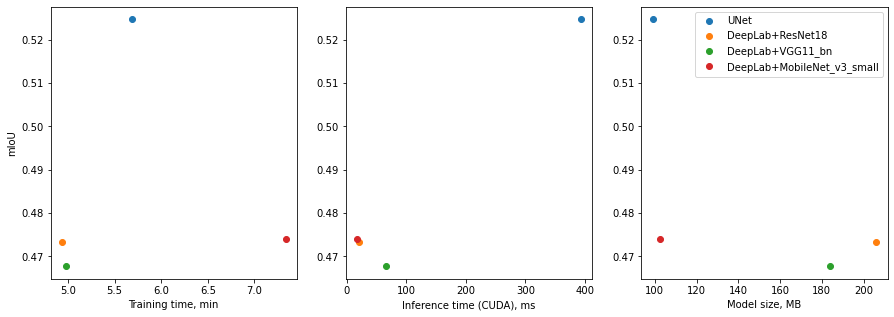

In [58]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# The time data is taken from Tensorboard graphs.

mIoU = {'UNet': .5247, 'DeepLab+ResNet18': .4734, 'DeepLab+VGG11_bn': .4677, 'DeepLab+MobileNet_v3_small': .474}

ax[0].plot(5 + 41 / 60, mIoU['UNet'], 'o', label='UNet')
ax[0].plot(4 + 56 / 60, mIoU['DeepLab+ResNet18'], 'o', label='DeepLab+ResNet18')
ax[0].plot(4 + 59 / 60, mIoU['DeepLab+VGG11_bn'], 'o', label='DeepLab+VGG11_bn')
ax[0].plot(7 + 20 / 60, mIoU['DeepLab+MobileNet_v3_small'], 'o', label='DeepLab+MobileNet_v3_small')

ax[0].set_ylabel('mIoU')
ax[0].set_xlabel('Training time, min')

ax[1].plot(393.149, mIoU['UNet'], 'o')
ax[1].plot(19.996, mIoU['DeepLab+ResNet18'], 'o')
ax[1].plot(65.232, mIoU['DeepLab+VGG11_bn'], 'o')
ax[1].plot(17.384, mIoU['DeepLab+MobileNet_v3_small'], 'o')

ax[1].set_xlabel('Inference time (CUDA), ms')

ax[2].plot(101291 / 1024, mIoU['UNet'], 'o', label='UNet')
ax[2].plot(211121 / 1024, mIoU['DeepLab+ResNet18'], 'o', label='DeepLab+ResNet18')
ax[2].plot(188205 / 1024, mIoU['DeepLab+VGG11_bn'], 'o', label='DeepLab+VGG11_bn')
ax[2].plot(104997 / 1024, mIoU['DeepLab+MobileNet_v3_small'], 'o', label='DeepLab+MobileNet_v3_small')

ax[2].set_xlabel('Model size, MB')

ax[2].legend();

In terms of training time, UNet proved to be the most efficient choice because, while taking just a little more time than DeepLab+ResNet18 or DeepLab+VGG11_bn, it achieves the best mIoU score. However, this could be due to some randomness in CUDA and train dataloader, so it is recommended to conduct a few more experiments to say for sure.

In terms of inference time, DeepLab+MobileNet_v3_small has demonstrated the best performance, also achieving the best mIoU score at the same time among the fastest models (not taking UNet into account here because its inference time is unreasonably large).

In terms of model size, UNet is the absolute winner because it has the smallest size while providing the best mIoU score.

#### Task 4.

Pick the best model according to **mIoU** and look at the visualized predictions on the validation set in the TensorBoard. For each segmentation class, find the good examples (if they are available), and the failure cases. Provide the zoomed-in examples and their analysis below. Please do not attach full validation images, only the areas of interest which you should crop manually.

Good examples:

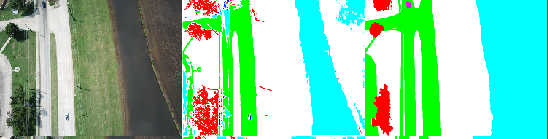

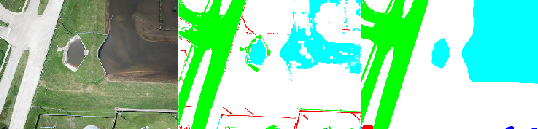

Bad examples: the model seems to be biased to finding water which is in fact not there.

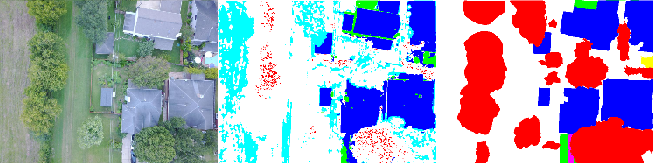

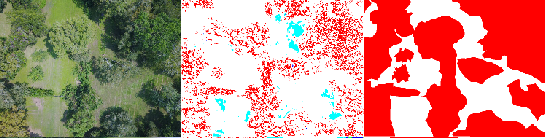

**<font color='red'>Before the submission please convert your notebook to .py file and check that it runs correctly. How to get .py file in Colab: File -> Download -> Download .py**
Left side menu in Colab -> Files -> Upload your script
and then check.

In [61]:
!python hw2_semantic_segmentation_Vergazov_Artem_attempt_1.py

^C


You can replace TODO strings to None